In [1]:
%matplotlib inline

In [2]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from lightkurve import TessLightCurveFile
from astropy.coordinates import SkyCoord
import astropy.units as u
import lightkurve

import exoplanet as xo
import pymc3 as pm
import theano.tensor as tt
import theano
from scipy.signal import savgol_filter
import pandas as pd
from astropy.time import Time

In [3]:
print(xo.__version__)
print(theano.__version__)
print(pm.__version__)

0.1.5
1.0.4
3.6


In [4]:
target = 'AU Mic'
lcf = lightkurve.search_lightcurvefile(target).download(quality_bitmask='hard',)
lc = lcf.get_lightcurve('PDCSAP_FLUX').normalize()

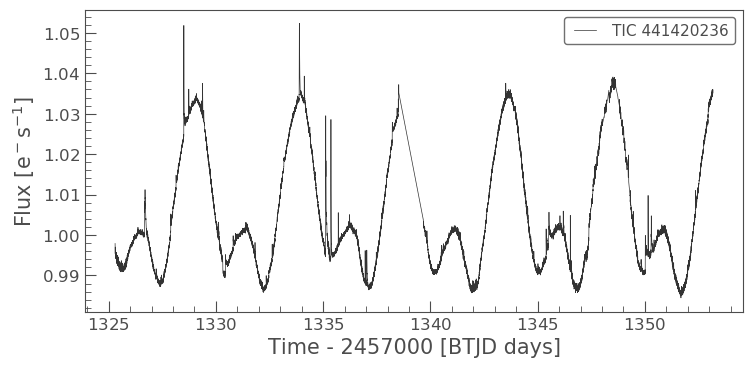

In [5]:
lc_hdr = lcf.header(ext=1)
lc.plot(normalize=False)

In [6]:
texp = lc_hdr["FRAMETIM"] * lc_hdr["NUM_FRM"]
texp /= 60.0 * 60.0 * 24.0
ref_time = 0.5 * (lc.time.min() + lc.time.max())
flux = (lc.flux - 1.0) * 1e3
time = lc.time
flux_err = lc.flux_err
m = np.isfinite(time) & np.isfinite(flux)
time = time[m]
flux = flux[m]
flux_err = flux_err[m]

In [7]:
# Identify outliers
m = np.ones(len(flux), dtype=bool)
for i in range(20):
    y_prime = np.interp(time, time[m], flux[m])
    smooth = savgol_filter(y_prime, 301, polyorder=3)
    resid = flux - smooth
    sigma = np.sqrt(np.mean(resid**2))
    m0 = resid < sigma*1.5
    if m.sum() == m0.sum():
        m = m0
        break
    m = m0

(1330, 1331)

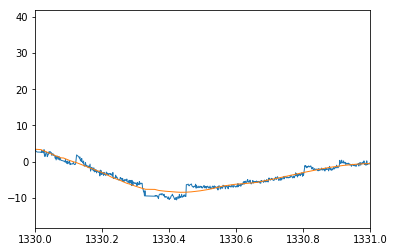

In [8]:
plt.plot(time[m], flux[m], lw=1)
plt.plot(time, smooth, lw=1)
plt.xlim(1330,1331)

In [9]:
spitzer = pd.read_csv('spitzer.csv')
time = np.ascontiguousarray(time[m] - ref_time, dtype=np.float64)
flux = np.ascontiguousarray(flux[m], dtype=np.float64)
flux_err = np.ascontiguousarray(flux_err[m], dtype=np.float64)

x = time
y = flux
yerr = flux_err

In [10]:
x_spitzer = Time(spitzer.BMJD, format='mjd', scale='tdb').jd - 2457000 - ref_time
y_spitzer = (spitzer.SAP_pld_ramp.values - 1.0) * 1.E3
yerr_spitzer = np.ones_like(y_spitzer) * np.std(y_spitzer[1700:2000])

texp_spitzer = np.median(np.diff(x_spitzer))

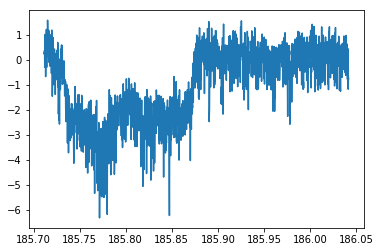

In [11]:
plt.plot(x_spitzer, y_spitzer)

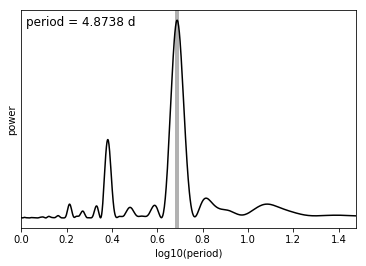

In [12]:
results = xo.estimators.lomb_scargle_estimator(
    x, y, max_peaks=1, min_period=1.0, max_period=30.0,
    samples_per_peak=50)

peak = results["peaks"][0]
ls_period = peak["period"]
freq, power = results["periodogram"]
plt.plot(-np.log10(freq), power, "k")
plt.axvline(np.log10(ls_period), color="k", lw=4, alpha=0.3)
plt.xlim((-np.log10(freq)).min(), (-np.log10(freq)).max())
plt.annotate("period = {0:.4f} d".format(ls_period),
             (0, 1), xycoords="axes fraction",
             xytext=(5, -5), textcoords="offset points",
             va="top", ha="left", fontsize=12)
plt.yticks([])
plt.xlabel("log10(period)")
plt.ylabel("power");

In [91]:
def build_model(mask=None, mask_spitzer=None, start=None):
    guess_p_period = 8.463, 30.537
    guess_p_t0 = -8.84, 2.9955
    guess_p_depth = 0.04, 0.02
    if mask is None:
        mask = np.ones_like(x, dtype=bool)
        mask_spitzer = np.ones_like(x_spitzer, dtype=bool)
    with pm.Model() as model:

        # The mean flux of the time series
        mean = pm.Normal("mean", mu=6, sd=15.0)
        mean_spitzer = pm.Normal("mean_spitzer", mu=0, sd=3.0)

        # A jitter term describing excess white noise
        logs2 = pm.Normal("logs2", mu=2*np.log(np.min(yerr[mask])), sd=5.0)
        logs2_spitzer = pm.Normal("logs2_spitzer", mu=2*np.log(np.min(yerr_spitzer[mask_spitzer])), sd=5.0)

        # A SHO term to capture long term trends
        logS = pm.Normal("logS", mu=0.0, sd=15.0, testval=np.log(np.var(y[mask])))
        logw = pm.Normal("logw", mu=np.log(2*np.pi/10.0), sd=10.0)
        term1 = xo.gp.terms.SHOTerm(log_S0=logS, log_w0=logw, Q=1/np.sqrt(2))
        
        logS_spitzer = pm.Normal("logS_spitzer", mu=0.01, sd=15.0, testval=np.log(
            np.var(y_spitzer[mask_spitzer])))
        logw_spitzer = pm.Normal("logw_spitzer", mu=np.log(2*np.pi/10.0), sd=10.0)
        term1_spitzer = xo.gp.terms.SHOTerm(log_S0=logS_spitzer, log_w0=logw_spitzer, Q=1/np.sqrt(2))
        
        # The parameters of the RotationTerm kernel
        logamp = pm.Normal("logamp", mu=np.log(np.var(y[mask])), sd=5.0)
        logperiod = pm.Normal("logperiod", mu=np.log(ls_period), sd=0.2)
        period = pm.Deterministic("period", tt.exp(logperiod))
        logQ0 = pm.Normal("logQ0", mu=1.0, sd=10.0)
        logdeltaQ = pm.Normal("logdeltaQ", mu=2.0, sd=10.0)
        mix = pm.Uniform("mix", lower=0, upper=1.0)
        term2 = xo.gp.terms.RotationTerm(
            log_amp=logamp,
            period=period,
            log_Q0=logQ0,
            log_deltaQ=logdeltaQ,
            mix=mix
        )

        u_star = xo.distributions.QuadLimbDark("u_star",
                                              testval=np.array([0.4, 0.2]))
        u_star_spitzer = xo.distributions.QuadLimbDark("u_star_spitzer",
                                              testval=np.array([0.4, 0.2]))
        R_star = 0.75, 0.03
        Rho_star = 1.7
        r_star = pm.Normal("r_star", mu=R_star[0], sd=R_star[1])
        logrho_star = pm.Normal("logrho_star", mu=np.log(Rho_star), sd=0.4)
        rho_star = pm.Deterministic("rho_star", tt.exp(logrho_star))
        pm.Potential("r_star_prior", tt.switch(r_star > 0, 0, -np.inf))
        logP = pm.Normal("logP", mu=np.log(guess_p_period), sd=0.2, shape=2, 
                         testval=np.log(guess_p_period))
        t0 = pm.Normal("t0", mu=guess_p_t0, sd=0.1, shape=2, testval=guess_p_t0)
        
        logror = pm.Bound(pm.Normal, lower=np.log(0.0), upper=np.log(0.3))("logror", 
                                                                            mu=np.log(guess_p_depth),
                                                                            sd=2, shape=2)
        ror = pm.Deterministic("ror", tt.exp(logror))
        b_param = pm.Uniform("b_param", lower=0, upper=1, shape=2, testval=[0.2, 0.3])
        b = pm.Deterministic("b", b_param * (1 + ror))
        
        ecc = pm.Bound(pm.Beta, lower=0.0, upper=0.8)("ecc", alpha=0.867, beta=3.03, testval=0.1,
                                                     shape=2)
#         ecc = pm.Beta('ecc', alpha=0.867, beta=3.03, testval=[0.1,0.05], shape=2)
        omega = xo.distributions.Angle("omega", shape=2)
        
#         ecc= [0., 0.]
#         omega = [0, 0]

        
#         pm.Potential("ror_prior_lo", tt.switch(tt.all(0.01 < ror), 0.0, -np.inf))
#         pm.Potential("ror_prior_hi", tt.switch(tt.all(ror < 0.3), 0.0, -np.inf))  
#         pm.Potential("ror_prior", -tt.log(ror))

    #         pm.Potential("b_prior",  tt.switch(b < 1, 0, -np.inf))
        p_period = pm.Deterministic("p_period", tt.exp(logP))
        
        # this prior seems to be needed
        pm.Potential("p_period_prior", tt.switch((p_period < 16.96) | (p_period > 20), 0, -np.inf))
        
        r_pl = pm.Deterministic("r_pl", r_star * ror)
        r_ple = pm.Deterministic("r_ple", r_star * ror / 0.009155)
        orbit = xo.orbits.KeplerianOrbit(
            r_star=r_star,
            period=p_period, t0=t0, b=b,
            rho_star=rho_star, ecc=ecc, omega=omega)
        light_curves = xo.StarryLightCurve(u_star).get_light_curve(
            orbit=orbit, r=r_pl, t=x[mask], texp=texp)*1e3
        light_curves_spitzer = xo.StarryLightCurve(u_star_spitzer).get_light_curve(
            orbit=orbit, r=r_pl, t=x_spitzer[mask_spitzer], texp=texp_spitzer)*1e3
        light_curve = pm.math.sum(light_curves, axis=-1)
        light_curve_spitzer = pm.math.sum(light_curves_spitzer, axis=-1)
        pm.Deterministic("light_curve", light_curve)
        pm.Deterministic("light_curve_spitzer", light_curve_spitzer)
        model.light_curves = light_curves
        model.light_curves_spitzer = light_curves_spitzer

        # Set up the Gaussian Process model
        kernel = term1 + term2
        gp = xo.gp.GP(kernel, x[mask], yerr[mask]**2 + tt.exp(logs2), J=6)
        
        kernel_spitzer = term1_spitzer
        gp_spitzer = xo.gp.GP(kernel_spitzer, x_spitzer[mask_spitzer],
                              yerr_spitzer[mask_spitzer]**2 + tt.exp(logs2_spitzer), J=2)

        # Compute the Gaussian Process likelihood and add it into the
        # the PyMC3 model as a "potential"
        pm.Potential("loglike", gp.log_likelihood(y[mask] - mean - light_curve))
        pm.Potential("loglike_spitzer", gp_spitzer.log_likelihood(y_spitzer[mask_spitzer] -
                                                          mean_spitzer - light_curve_spitzer))

        # Compute the mean model prediction for plotting purposes
        pm.Deterministic("pred", gp.predict())
        pm.Deterministic("pred_spitzer", gp_spitzer.predict())

        # Optimize to find the maximum a posteriori parameters
        if start is None:
            start = model.test_point
        map_soln = xo.optimize(start=start, vars=[mean, logs2])
        map_soln = xo.optimize(start=map_soln, vars=[mean, logs2, logS, logw,
                                                     mean_spitzer, logs2_spitzer, logS_spitzer,
                                                    logw_spitzer])
        map_soln = xo.optimize(start=map_soln, vars=[mean, logs2, logamp, logQ0, logdeltaQ, mix])
        map_soln = xo.optimize(start=map_soln, vars=[model.logror, model.b_param, ])
        map_soln = xo.optimize(start=map_soln, vars=[mean, logs2, logamp, logQ0, logdeltaQ, mix])
        map_soln = xo.optimize(start=map_soln, vars=[model.logror, model.b_param])
    return model, map_soln

model0, map_soln0 = build_model()

optimizing logp for variables: ['logs2', 'mean']


/home/tom/anaconda3/envs/exoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/home/tom/anaconda3/envs/exoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


message: Optimization terminated successfully.
logp: -2443139563.9596443 -> -43885.44197358914
optimizing logp for variables: ['logw_spitzer', 'logS_spitzer', 'logs2_spitzer', 'mean_spitzer', 'logw', 'logS', 'logs2', 'mean']


/home/tom/anaconda3/envs/exoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/home/tom/anaconda3/envs/exoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


message: Desired error not necessarily achieved due to precision loss.
logp: -43885.44197358914 -> -11863.58848475363
optimizing logp for variables: ['mix_interval__', 'logdeltaQ', 'logQ0', 'logamp', 'logs2', 'mean']
message: Optimization terminated successfully.
logp: -11863.58848475363 -> -11852.938696769783
optimizing logp for variables: ['b_param_interval__', 'logror_upperbound__']


/home/tom/anaconda3/envs/exoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/home/tom/anaconda3/envs/exoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/home/tom/anaconda3/envs/exoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is depreca

message: Optimization terminated successfully.
logp: -11852.938696769783 -> -11362.189981031126
optimizing logp for variables: ['mix_interval__', 'logdeltaQ', 'logQ0', 'logamp', 'logs2', 'mean']
message: Optimization terminated successfully.
logp: -11362.189981031126 -> -11306.065288143642
optimizing logp for variables: ['b_param_interval__', 'logror_upperbound__']
message: Optimization terminated successfully.
logp: -11306.065288143642 -> -11306.030876286995


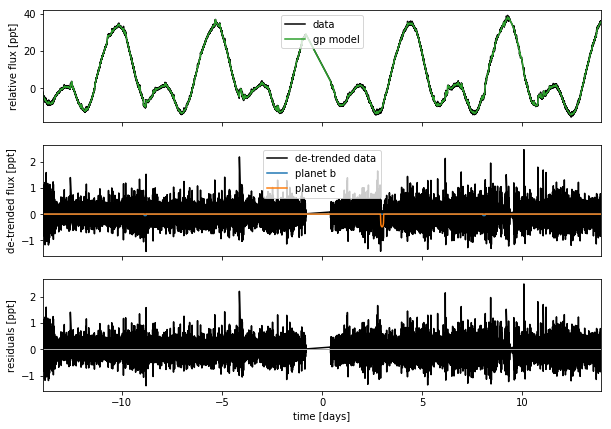

In [92]:
def plot_light_curve(model, soln, mask=None):
    if mask is None:
        mask = np.ones(len(x), dtype=bool)

    fig, axes = plt.subplots(3, 1, figsize=(10, 7), sharex=True)

    ax = axes[0]
    ax.plot(x[mask], y[mask], "k", label="data")
    gp_mod = xo.utils.eval_in_model(model.pred, soln, model=model)
    gp_mod += soln["mean"]
    ax.plot(x[mask], gp_mod, color="C2", label="gp model")
    ax.legend(fontsize=10)
    ax.set_ylabel("relative flux [ppt]")

    ax = axes[1]
    ax.plot(x[mask], y[mask] - gp_mod, "k", label="de-trended data")
    light_curves = xo.utils.eval_in_model(model.light_curves, soln, model=model)
    for i, l in enumerate(["b", "c",]):
        mod = light_curves[:, i]
        ax.plot(x[mask], mod, label="planet {0}".format(l))
    ax.legend(fontsize=10)
    ax.set_ylabel("de-trended flux [ppt]")

    ax = axes[2]
    mod = gp_mod + np.sum(light_curves, axis=-1)
    ax.plot(x[mask], y[mask] - mod, "k")
    ax.axhline(0, color="#aaaaaa", lw=1)
    ax.set_ylabel("residuals [ppt]")
    ax.set_xlim(x[mask].min(), x[mask].max())
    ax.set_xlabel("time [days]")
    
    return fig
    
plot_light_curve(model0, map_soln0);

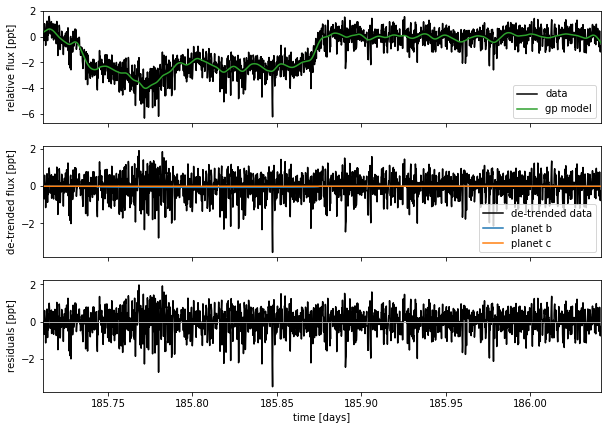

In [93]:
def plot_light_curve_spitzer(model, soln, mask=None):
    if mask is None:
        mask = np.ones(len(x_spitzer), dtype=bool)

    fig, axes = plt.subplots(3, 1, figsize=(10, 7), sharex=True)

    ax = axes[0]
    ax.plot(x_spitzer[mask], y_spitzer[mask], "k", label="data")
    gp_mod = xo.utils.eval_in_model(model.pred_spitzer, soln, model=model)
    gp_mod += soln["mean_spitzer"]
    ax.plot(x_spitzer[mask], gp_mod, color="C2", label="gp model")
    ax.legend(fontsize=10)
    ax.set_ylabel("relative flux [ppt]")

    ax = axes[1]
    ax.plot(x_spitzer[mask], y_spitzer[mask] - gp_mod, "k", label="de-trended data")
    light_curves = xo.utils.eval_in_model(model.light_curves_spitzer, soln, model=model)
    for i, l in enumerate(["b","c"]):
        mod = light_curves[:, i]
        ax.plot(x_spitzer[mask], mod, label="planet {0}".format(l))
    ax.legend(fontsize=10)
    ax.set_ylabel("de-trended flux [ppt]")

    ax = axes[2]
    mod = gp_mod + np.sum(light_curves, axis=-1)
    ax.plot(x_spitzer[mask], y_spitzer[mask] - mod, "k")
    ax.axhline(0, color="#aaaaaa", lw=1)
    ax.set_ylabel("residuals [ppt]")
    ax.set_xlim(x_spitzer[mask].min(), x_spitzer[mask].max())
    ax.set_xlabel("time [days]")
    
    return fig

plot_light_curve_spitzer(model0, map_soln0);

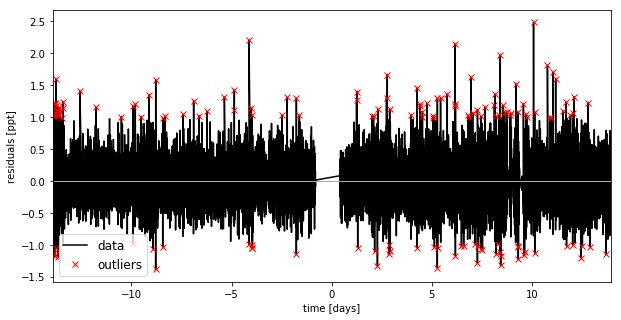

In [98]:
mod = map_soln0["pred"] + map_soln0["mean"] + map_soln0["light_curve"]
resid = y - mod
rms = np.sqrt(np.median(resid**2))
mask = np.abs(resid) < 5 * rms

plt.figure(figsize=(10, 5))
plt.plot(x, resid, "k", label="data")
plt.plot(x[~mask], resid[~mask], "xr", label="outliers")
plt.axhline(0, color="#aaaaaa", lw=1)
plt.ylabel("residuals [ppt]")
plt.xlabel("time [days]")
plt.legend(fontsize=12, loc=3)
plt.xlim(x.min(), x.max());

/home/tom/anaconda3/envs/exoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


optimizing logp for variables: ['logs2', 'mean']


/home/tom/anaconda3/envs/exoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/home/tom/anaconda3/envs/exoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


message: Desired error not necessarily achieved due to precision loss.
logp: -10254.117659169995 -> -10190.71862713619
optimizing logp for variables: ['logw_spitzer', 'logS_spitzer', 'logs2_spitzer', 'mean_spitzer', 'logw', 'logS', 'logs2', 'mean']


/home/tom/anaconda3/envs/exoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/home/tom/anaconda3/envs/exoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


message: Optimization terminated successfully.
logp: -10190.71862713619 -> -9970.170778362495
optimizing logp for variables: ['mix_interval__', 'logdeltaQ', 'logQ0', 'logamp', 'logs2', 'mean']
message: Optimization terminated successfully.
logp: -9970.170778362495 -> -9957.826006214118
optimizing logp for variables: ['b_param_interval__', 'logror_upperbound__']


/home/tom/anaconda3/envs/exoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/home/tom/anaconda3/envs/exoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


message: Desired error not necessarily achieved due to precision loss.
logp: -9957.826006214118 -> -9950.413152712052
optimizing logp for variables: ['mix_interval__', 'logdeltaQ', 'logQ0', 'logamp', 'logs2', 'mean']
message: Optimization terminated successfully.
logp: -9950.413152712052 -> -9950.125519232228
optimizing logp for variables: ['b_param_interval__', 'logror_upperbound__']
message: Optimization terminated successfully.
logp: -9950.125519232228 -> -9950.115956915399


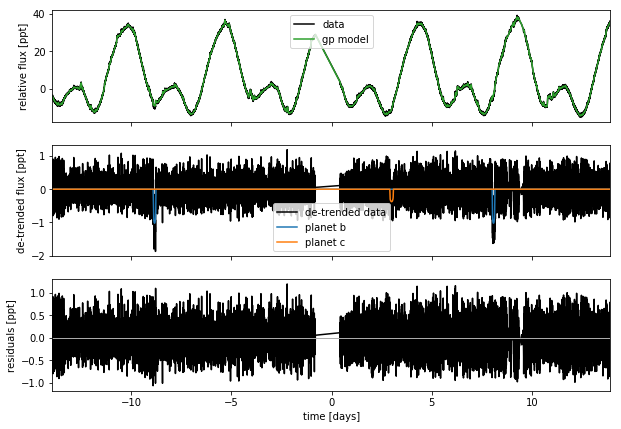

In [101]:
model, map_soln = build_model(mask, np.ones_like(y_spitzer, dtype=bool), map_soln0)
fig = plot_light_curve(model, map_soln, mask)
# fig.savefig('gp-map-aumic.png', dpi=200)

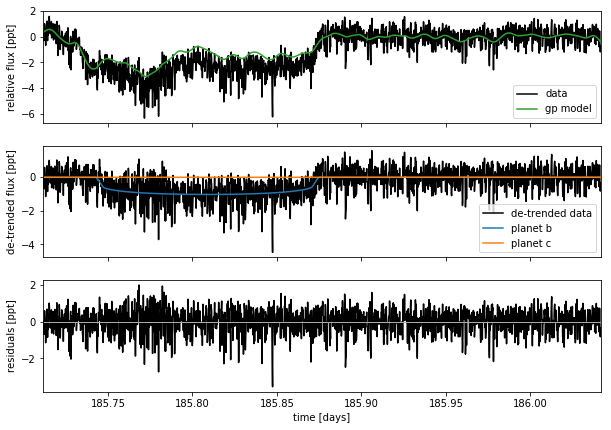

In [102]:
plot_light_curve_spitzer(model, map_soln);

In [103]:
sampler = xo.PyMC3Sampler(window=200, start=500, finish=1000)
with model:
    burnin = sampler.tune(tune=5000, start=map_soln, step_kwargs=dict(target_accept=0.9), )

/home/tom/anaconda3/envs/exoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Sampling 4 chains: 100%|██████████| 808/808 [24:02<00:00, 12.11s/draws]
The chain contains only diverging samples. The model is probably misspecified.
The chain contains only diverging samples. The model is probably misspecified.
Sampling 4 chains: 100%|██████████| 12408/12408 [23:17:03<00:00, 23.29s/draws]  
The chain contains only diverging samples. The model is probably misspecified.
Sampling 4 chains: 100%|██████████| 4008/4008 [6:41:36<00:00, 21.60s/draws]  


In [104]:
start, step = sampler._get_start_and_step()
with model:
    step = pm.NUTS(potential=step.potential, target_accept=0.9)
    trace = pm.sample(draws=3000, tune=200, step=step, start=start)

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [omega, ecc, b_param, logror, t0, logP, logrho_star, r_star, u_star_spitzer, u_star, mix, logdeltaQ, logQ0, logperiod, logamp, logw_spitzer, logS_spitzer, logw, logS, logs2_spitzer, logs2, mean_spitzer, mean]
Sampling 4 chains: 100%|██████████| 12800/12800 [40:59:13<00:00, 19.99s/draws]   
There were 53 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The acceptance probability does not match the target. It is 0.993903765898127, but should be close to 0.9. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 2421 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8058076663200467, but should be close to 0.9. Try to increase

In [105]:
pm.summary(trace, varnames= ['b', 'logror', 't0', 'logP', 'ecc', 'omega',
           'logrho_star', 'r_star', 'u_star', 'mix', 'logdeltaQ', 'logQ0', 'logperiod', 'logamp', 'logw', 'logS',
                             'logs2', 'mean', 'r_ple', 'p_period', 'ror'], alpha=0.317)

,mean,sd,mc_error,hpd_15.85,hpd_84.15,n_eff,Rhat
b__0,0.485298,0.204529,0.019783,0.375018,0.756151,2.805188,2.058344
b__1,0.638744,0.290934,0.025805,0.466503,1.077984,3.827978,1.603549
logror__0,-3.007285,0.056312,0.005214,-3.021783,-2.954291,5.048029,1.463237
logror__1,-4.171007,1.186656,0.106272,-5.410046,-3.220239,4.092281,1.516774
t0__0,-8.849772,0.006169,0.000614,-8.854438,-8.852069,2.018310,11.157532
t0__1,3.004637,0.048646,0.004264,2.953594,3.044479,5.486248,1.328104
logP__0,2.135722,0.000039,0.000004,2.135734,2.135755,2.057087,6.358927
logP__1,3.540078,0.224691,0.021457,3.346128,3.801462,3.629163,1.669421
ecc__0,0.113604,0.094831,0.008382,0.001109,0.172910,5.665941,1.345156
ecc__1,0.327020,0.214462,0.019211,0.008683,0.471652,12.343603,1.181291


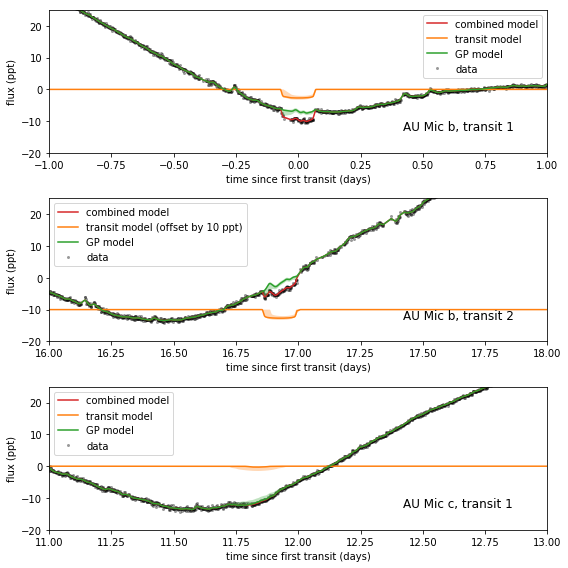

In [106]:
pred = np.percentile(trace["light_curve"] + trace["mean"][:, None] +
                     trace["pred"], [5,50,95], axis=0)
pred1 = np.percentile(trace["light_curve"], [5,50,95], axis=0)
pred2 = np.percentile(trace["pred"] + trace["mean"][:, None], [5,50,95], axis=0)

fig,  [ax1, ax2, ax3, ax4] = plt.subplots(4,1, figsize=[8, 8])
time = x[mask] - np.median(trace['t0'][:,0])

ax1.plot(time, pred[1], color='C3', label = 'combined model')
art = ax1.fill_between(time, pred[0], pred[2], color="C3", alpha=0.3,
                       zorder=1000)
art.set_edgecolor("none")

ax1.plot(time, pred1[1], color='C1', label = 'transit model')
art = ax1.fill_between(time, pred1[0], pred1[2], color="C1", alpha=0.3,
                       zorder=1000)
art.set_edgecolor("none")

ax1.plot(time, pred2[1], color='C2', label = 'GP model')
art = ax1.fill_between(time, pred2[0], pred2[2], color="C2", alpha=0.3,
                       zorder=1000)
art.set_edgecolor("none")

ax1.plot(time, y[mask], ".k", label="data",
         alpha=0.4, zorder=-1000, mec="none")

ax1.set_xlim(-1,1)
ax1.set_ylim(-20, 25)

ax1.legend()
ax1.set_xlabel("time since first transit (days)")
ax1.set_ylabel("flux (ppt)")

ax1.annotate('AU Mic b, transit 1', (0.7, 0.1), xycoords="axes fraction",
             xytext=(5, 5), textcoords="offset points",
             ha="left", va="bottom", fontsize=12)

ax2.plot(time, pred[1], color='C3', label = 'combined model')
art = ax2.fill_between(time, pred[0], pred[2], color="C3", alpha=0.3,
                       zorder=1000)
art.set_edgecolor("none")

ax2.plot(time, pred1[1] -10, color='C1', label = 'transit model (offset by 10 ppt)')
art = ax2.fill_between(time, pred1[0] -10, pred1[2]-10, color="C1", alpha=0.3,
                       zorder=1000)
art.set_edgecolor("none")

ax2.plot(time, pred2[1], color='C2', label = 'GP model')
art = ax2.fill_between(time, pred2[0], pred2[2], color="C2", alpha=0.3,
                       zorder=1000)
art.set_edgecolor("none")

ax2.plot(time, y[mask], ".k", label="data",
         alpha=0.4, zorder=-1000, mec="none")

ax2.set_xlim(16,18)
ax2.set_ylim(-20, 25)
ax2.legend()
ax2.set_xlabel("time since first transit (days)")
ax2.set_ylabel("flux (ppt)")

ax2.annotate('AU Mic b, transit 2', (0.7, 0.1), xycoords="axes fraction",
             xytext=(5, 5), textcoords="offset points",
             ha="left", va="bottom", fontsize=12)

ax3.plot(time, pred[1], color='C3', label = 'combined model')
art = ax3.fill_between(time, pred[0], pred[2], color="C3", alpha=0.3,
                       zorder=1000)
art.set_edgecolor("none")

ax3.plot(time, pred1[1], color='C1', label = 'transit model')
art = ax3.fill_between(time, pred1[0], pred1[2], color="C1", alpha=0.3,
                       zorder=1000)
art.set_edgecolor("none")

ax3.plot(time, pred2[1], color='C2', label = 'GP model')
art = ax3.fill_between(time, pred2[0], pred2[2], color="C2", alpha=0.3,
                       zorder=1000)
art.set_edgecolor("none")

ax3.plot(time, y[mask], ".k", label="data",
         alpha=0.4, zorder=-1000, mec="none")

ax3.set_xlim(11, 13)
ax3.set_ylim(-20, 25)
ax3.legend()
ax3.set_xlabel("time since first transit (days)")
ax3.set_ylabel("flux (ppt)")

ax3.annotate('AU Mic c, transit 1', (0.7, 0.1), xycoords="axes fraction",
             xytext=(5, 5), textcoords="offset points",
             ha="left", va="bottom", fontsize=12)



plt.tight_layout()
# plt.savefig('transits-GP-v2.png', dpi=200)

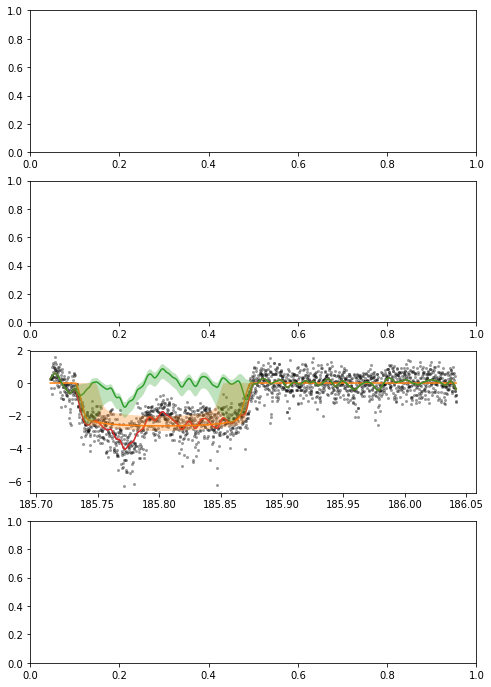

In [121]:
pred_spitzer = np.percentile(trace["light_curve_spitzer"] + trace["mean_spitzer"][:, None] +
                     trace["pred_spitzer"], [5,50,95], axis=0)
pred1_spitzer = np.percentile(trace["light_curve_spitzer"], [5,50,95], axis=0)
pred2_spitzer = np.percentile(trace["pred_spitzer"] + trace["mean_spitzer"][:, None], [5,50,95], axis=0)
fig,  [ax1, ax2, ax3, ax4] = plt.subplots(4,1, figsize=[8, 12])

ax3.plot(x_spitzer, pred_spitzer[1], color='C3', label = 'combined model')
art = ax3.fill_between(x_spitzer, pred_spitzer[0], pred_spitzer[2], color="C3", alpha=0.3,
                       zorder=1000)
art.set_edgecolor("none")

ax3.plot(x_spitzer, pred1_spitzer[1], color='C1', label = 'transit model')
art = ax3.fill_between(x_spitzer, pred1_spitzer[0], pred1_spitzer[2], color="C1", alpha=0.3,
                       zorder=1000)
art.set_edgecolor("none")

ax3.plot(x_spitzer, pred2_spitzer[1], color='C2', label = 'GP model')
art = ax3.fill_between(x_spitzer, pred2_spitzer[0], pred2_spitzer[2], color="C2", alpha=0.3,
                       zorder=1000)
art.set_edgecolor("none")

ax3.plot(x_spitzer, y_spitzer, ".k", label="data",
         alpha=0.4, zorder=-1000, mec="none")



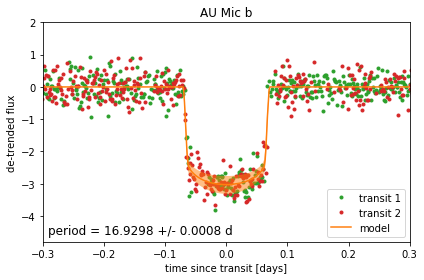

In [27]:
pmask = trace["p_period"][:, 0] < 16.96
for n, letter in enumerate("b"):
    plt.figure()
    
    # Compute the GP prediction
    gp_mod = np.median(trace["pred"][pmask], axis=0)
    offset = np.median(trace["mean"][pmask, None])

    # Get the posterior median orbital parameters
    p = np.median(trace["p_period"][pmask, n])
    t0 = np.median(trace["t0"][pmask, n])
    
    # Compute the median of posterior estimate of the contribution from
    # the other planet. Then we can remove this from the data to plot
    # just the planet we care about.
#     other = np.median(trace["light_curve"][:, :,], axis=0)

    # Plot the folded data
    x_fold = (x[mask] - t0 + 0.5*p) % p - 0.5*p
    mid = int(np.shape(x[mask])[0] / 2)
    x_fold0 = (x[mask][:mid] - t0 + 0.5*p) % p - 0.5*p
    x_fold1 = (x[mask][mid:] - t0 + 0.5*p) % p - 0.5*p
    if n == 0:
        plt.plot(x_fold0, y[mask][:mid] - gp_mod[:mid] - offset, ".C2", label="transit 1", zorder=-1000)
        plt.plot(x_fold1, y[mask][mid:] - gp_mod[mid:] - offset, ".C3", label="transit 2", zorder=-1000)
    elif n == 1:
        plt.plot(x_fold, y[mask] - gp_mod - offset, ".C2", label="data", zorder=-1000)
    
    # Plot the folded model
    inds = np.argsort(x_fold)
    inds = inds[np.abs(x_fold)[inds] < 0.3]
    pred = trace["light_curve"][:, inds][pmask] #- offset # + trace["mean"][:, None] 
    pred = np.percentile(pred, [16, 50, 84], axis=0)
    plt.plot(x_fold[inds], pred[1], color="C1", label="model")
    art = plt.fill_between(x_fold[inds], pred[0],
                           pred[2], color="C1", alpha=0.5,
                           zorder=1000)
    art.set_edgecolor("none")
    
    # Annotate the plot with the planet's period
    txt = "period = {0:.4f} +/- {1:.4f} d".format(
        np.mean(trace["p_period"][pmask, n]), np.std(trace["p_period"][pmask, n]))
    plt.annotate(txt, (0, 0), xycoords="axes fraction",
                 xytext=(5, 5), textcoords="offset points", 
                 ha="left", va="bottom", fontsize=12)

    plt.legend(fontsize=10, loc=4)
    plt.ylim(-4.8,2)
    plt.xlabel("time since transit [days]")
    plt.ylabel("de-trended flux")
    plt.title("AU Mic {0}".format(letter));
    plt.xlim(-0.3, 0.3)
    plt.tight_layout()
    plt.savefig('transit-plot-{}.png'.format(n+1), dpi=200)

ValueError: x and y must have same first dimension, but have shapes (15878,) and (1, 15878)

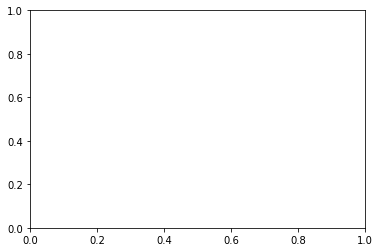

In [21]:
n = 0
resid = y[mask] - trace["pred"] - trace["mean"][:, None]
p = np.median(trace["p_period"][:, n])
t0 = np.median(trace["t0"][:, n])
x_fold = (x[mask] - t0 + 0.5*p) % p - 0.5*p
plt.plot(x_fold, np.percentile(resid, [16], axis=0), ".C2", label="data", zorder=-1000)
plt.plot(x_fold, np.percentile(resid, [50], axis=0), ".C2", label="data", zorder=-1000)
plt.plot(x_fold, np.percentile(resid, [84], axis=0), ".C2", label="data", zorder=-1000)

ValueError: x and y must have same first dimension, but have shapes (17461,) and (1,)

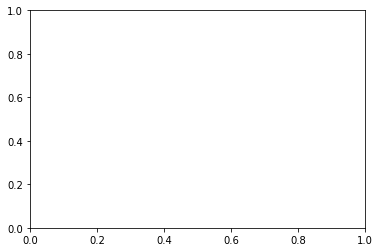

In [28]:
pred = np.percentile(resid, [16, 50, 84], axis=0)
plt.plot(x_fold, pred[1], ".C2", label="data", zorder=-1000)
plt.xlim(-0.3, 0.3)

In [25]:
map_soln0

{'mean': array(6.52882114),
 'logs2': array(-2.39280003),
 'logS': array(-2.98246078),
 'logw': array(3.37673192),
 'logamp': array(5.03765618),
 'logperiod': array(1.58292243),
 'logQ0': array(2.93485094),
 'logdeltaQ': array(9.9145813),
 'mix_interval__': array(-1.18581046),
 'u_star_quadlimbdark__': array([-0.57536414, -0.69314718]),
 'r_star': array(0.75),
 'logrho_star': array(-0.10536052),
 'logP': array([2.82825524, 3.42921204]),
 't0': array([-8.82244677,  2.9953215 ]),
 'logror_upperbound__': array([0.68895411, 1.26911893]),
 'b_param_interval__': array([-0.78097465, -0.67497811]),
 'ecc_interval__': array([-1.94591015, -1.94591015]),
 'omega_angle__': array([[0., 0.],
        [1., 1.]]),
 'period': array(4.86916485),
 'mix': array(0.23400907),
 'u_star': array([0.4, 0.2]),
 'rho_star': array(0.9),
 'logror': array([-3.19560421, -4.76168937]),
 'ror': array([0.04094178, 0.00855115]),
 'b_param': array([0.31410987, 0.33738306]),
 'b': array([0.32697008, 0.34026807]),
 'ecc': ar

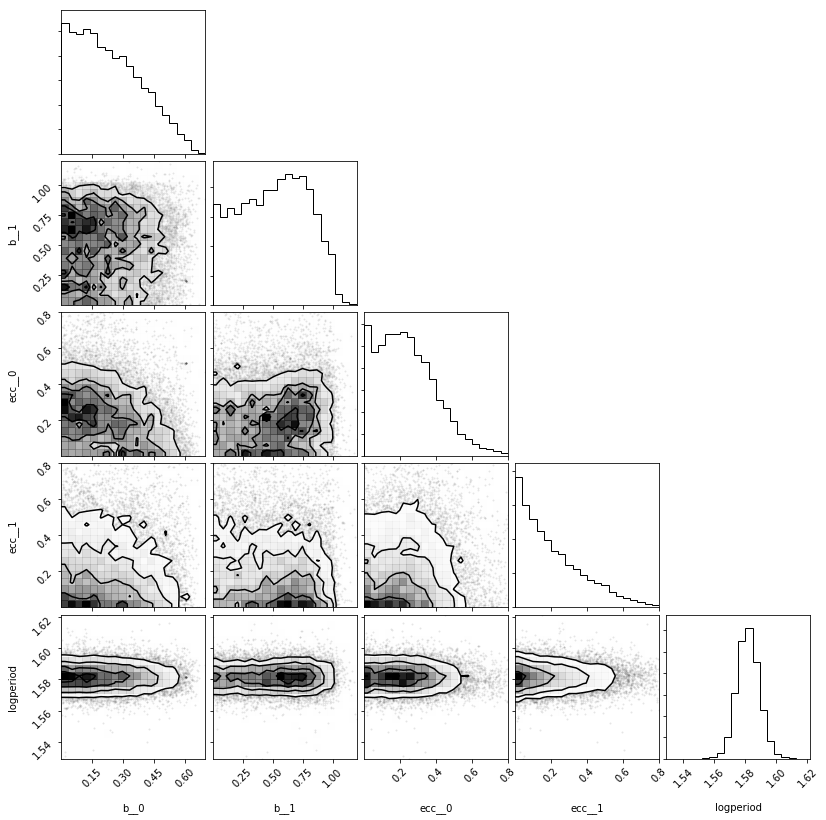

In [29]:
import corner
varnames = ["b", "ecc", 'logperiod']
samples = pm.trace_to_dataframe(trace, varnames=varnames)
corner.corner(samples);



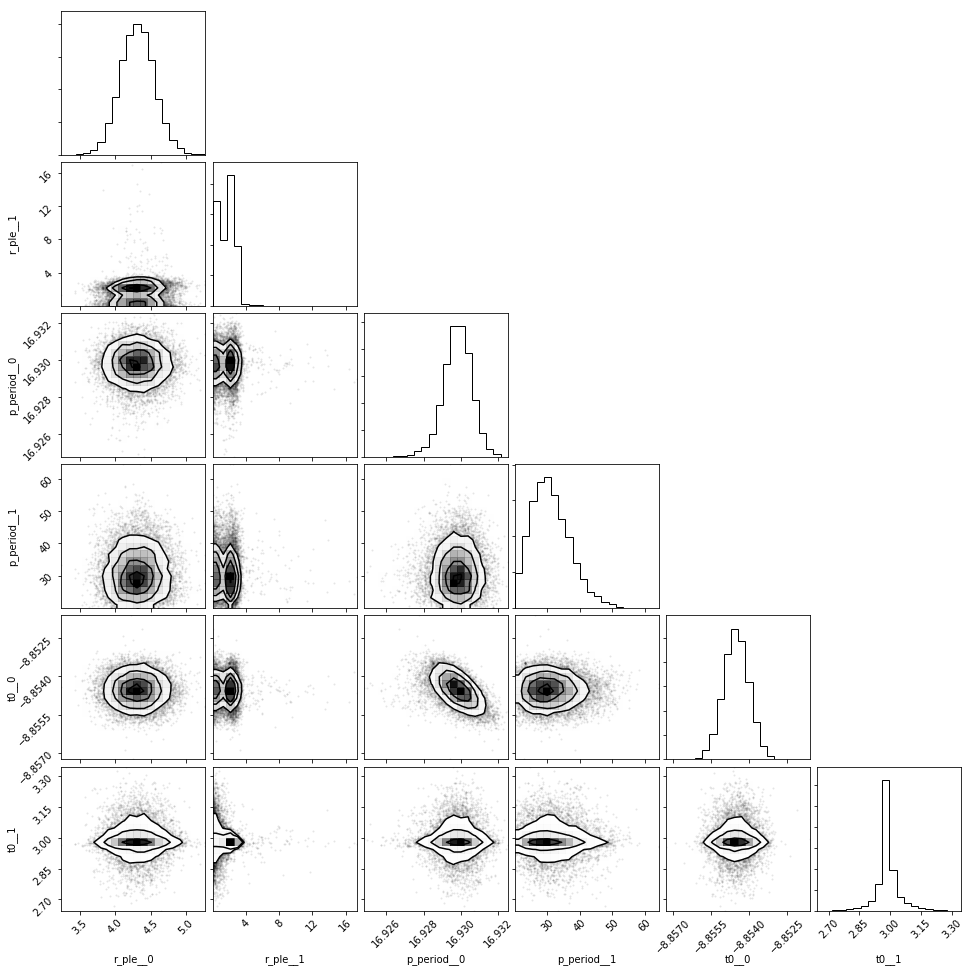

In [36]:
import corner
varnames = ["r_ple", "p_period", 't0']
samples = pm.trace_to_dataframe(trace, varnames=varnames)
corner.corner(samples);


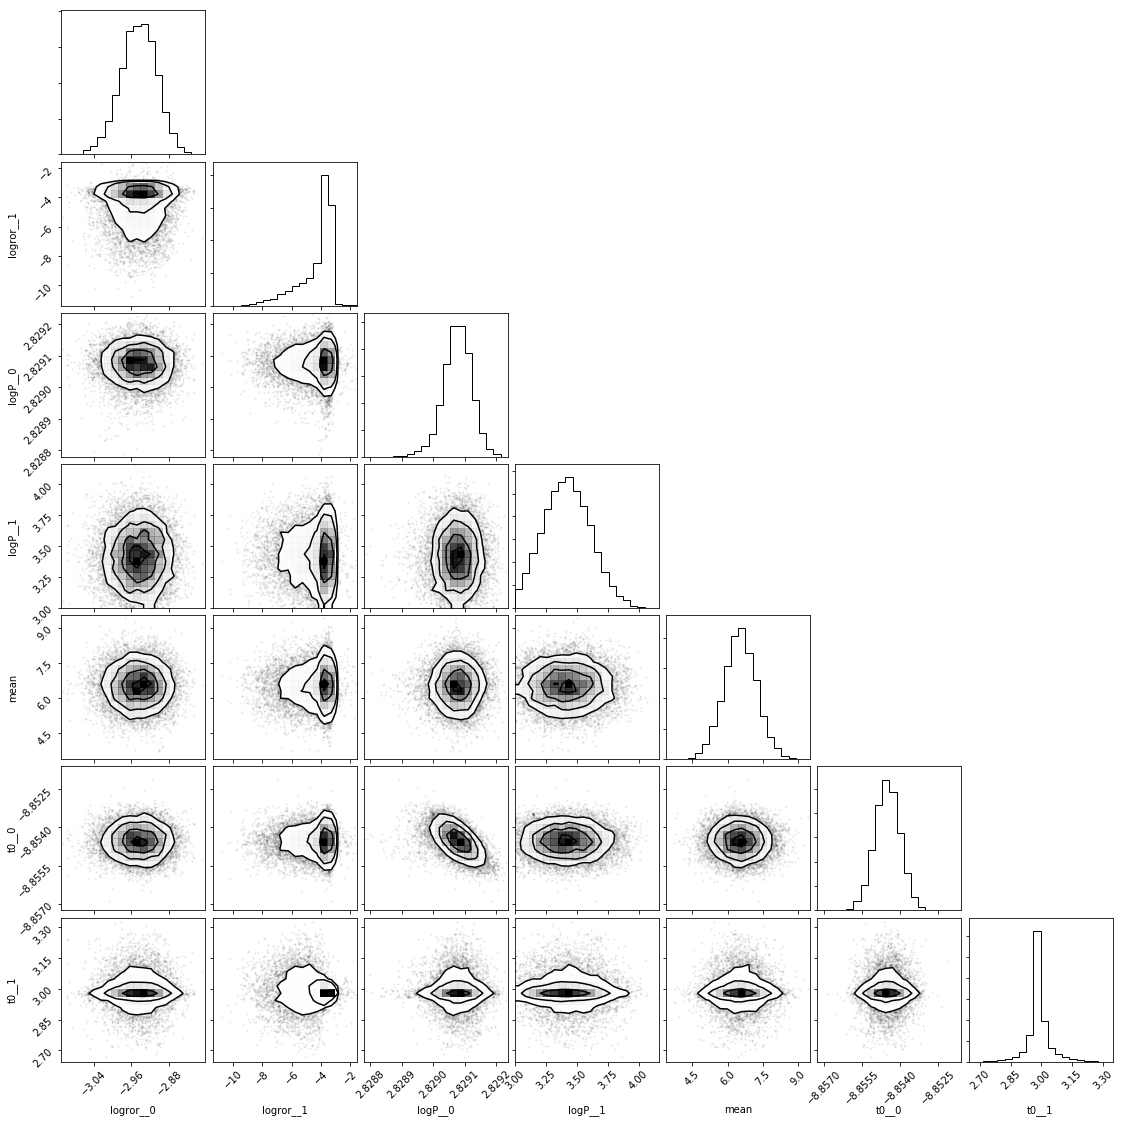

In [37]:
import corner
varnames = ["logror", "logP", 'mean', 't0']
samples = pm.trace_to_dataframe(trace, varnames=varnames)
corner.corner(samples);

In [32]:
pm.save_trace(trace)

'.pymc_2.trace'

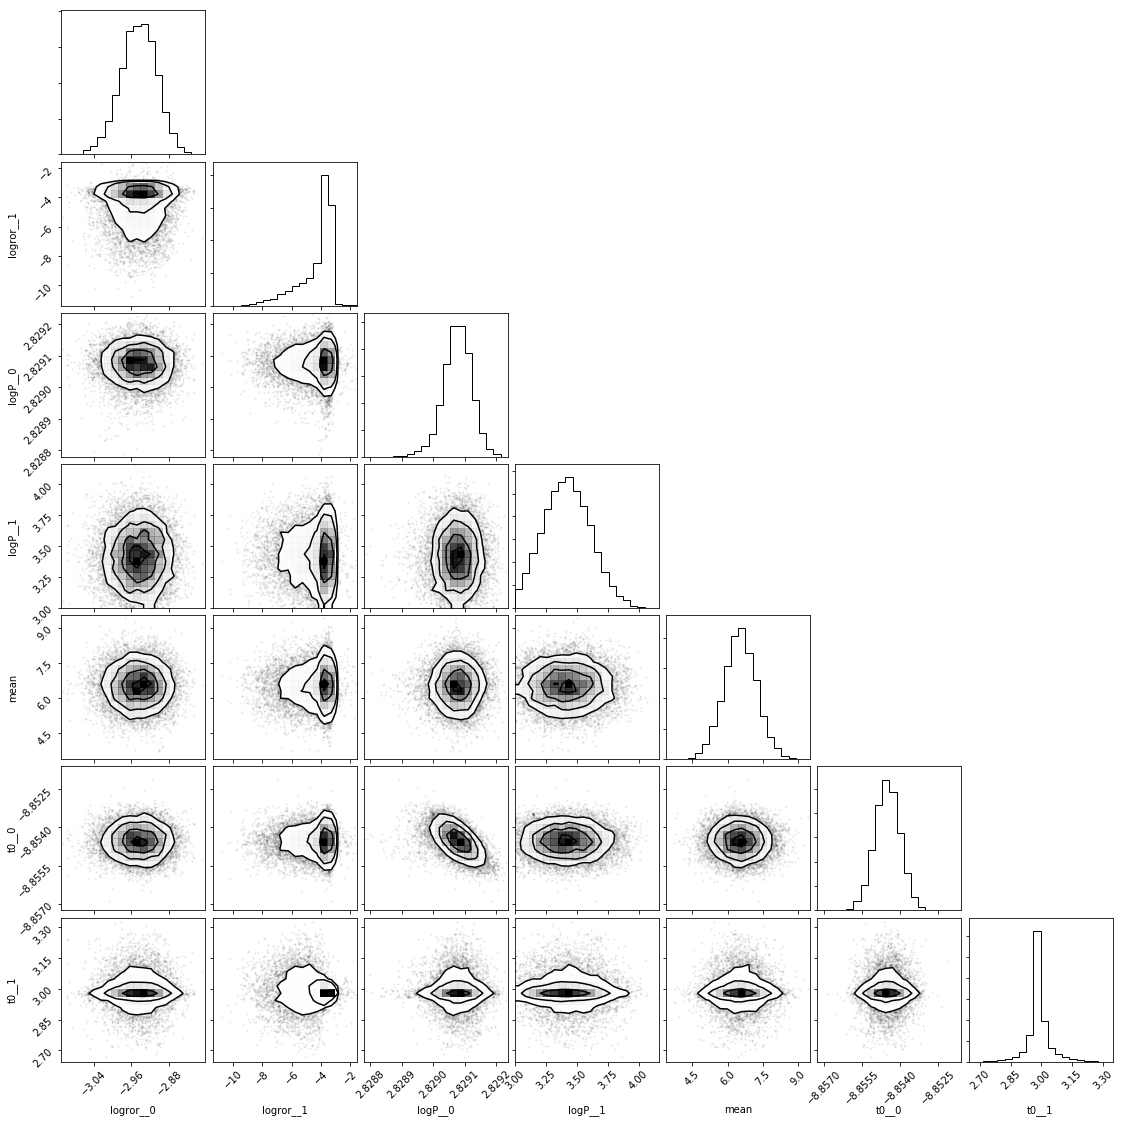

In [33]:
import corner
varnames = ["logror", "logP", 'mean', 't0']
samples = pm.trace_to_dataframe(trace, varnames=varnames)
samples = samples.loc[samples.logP__0 < 2.8304]
corner.corner(samples);

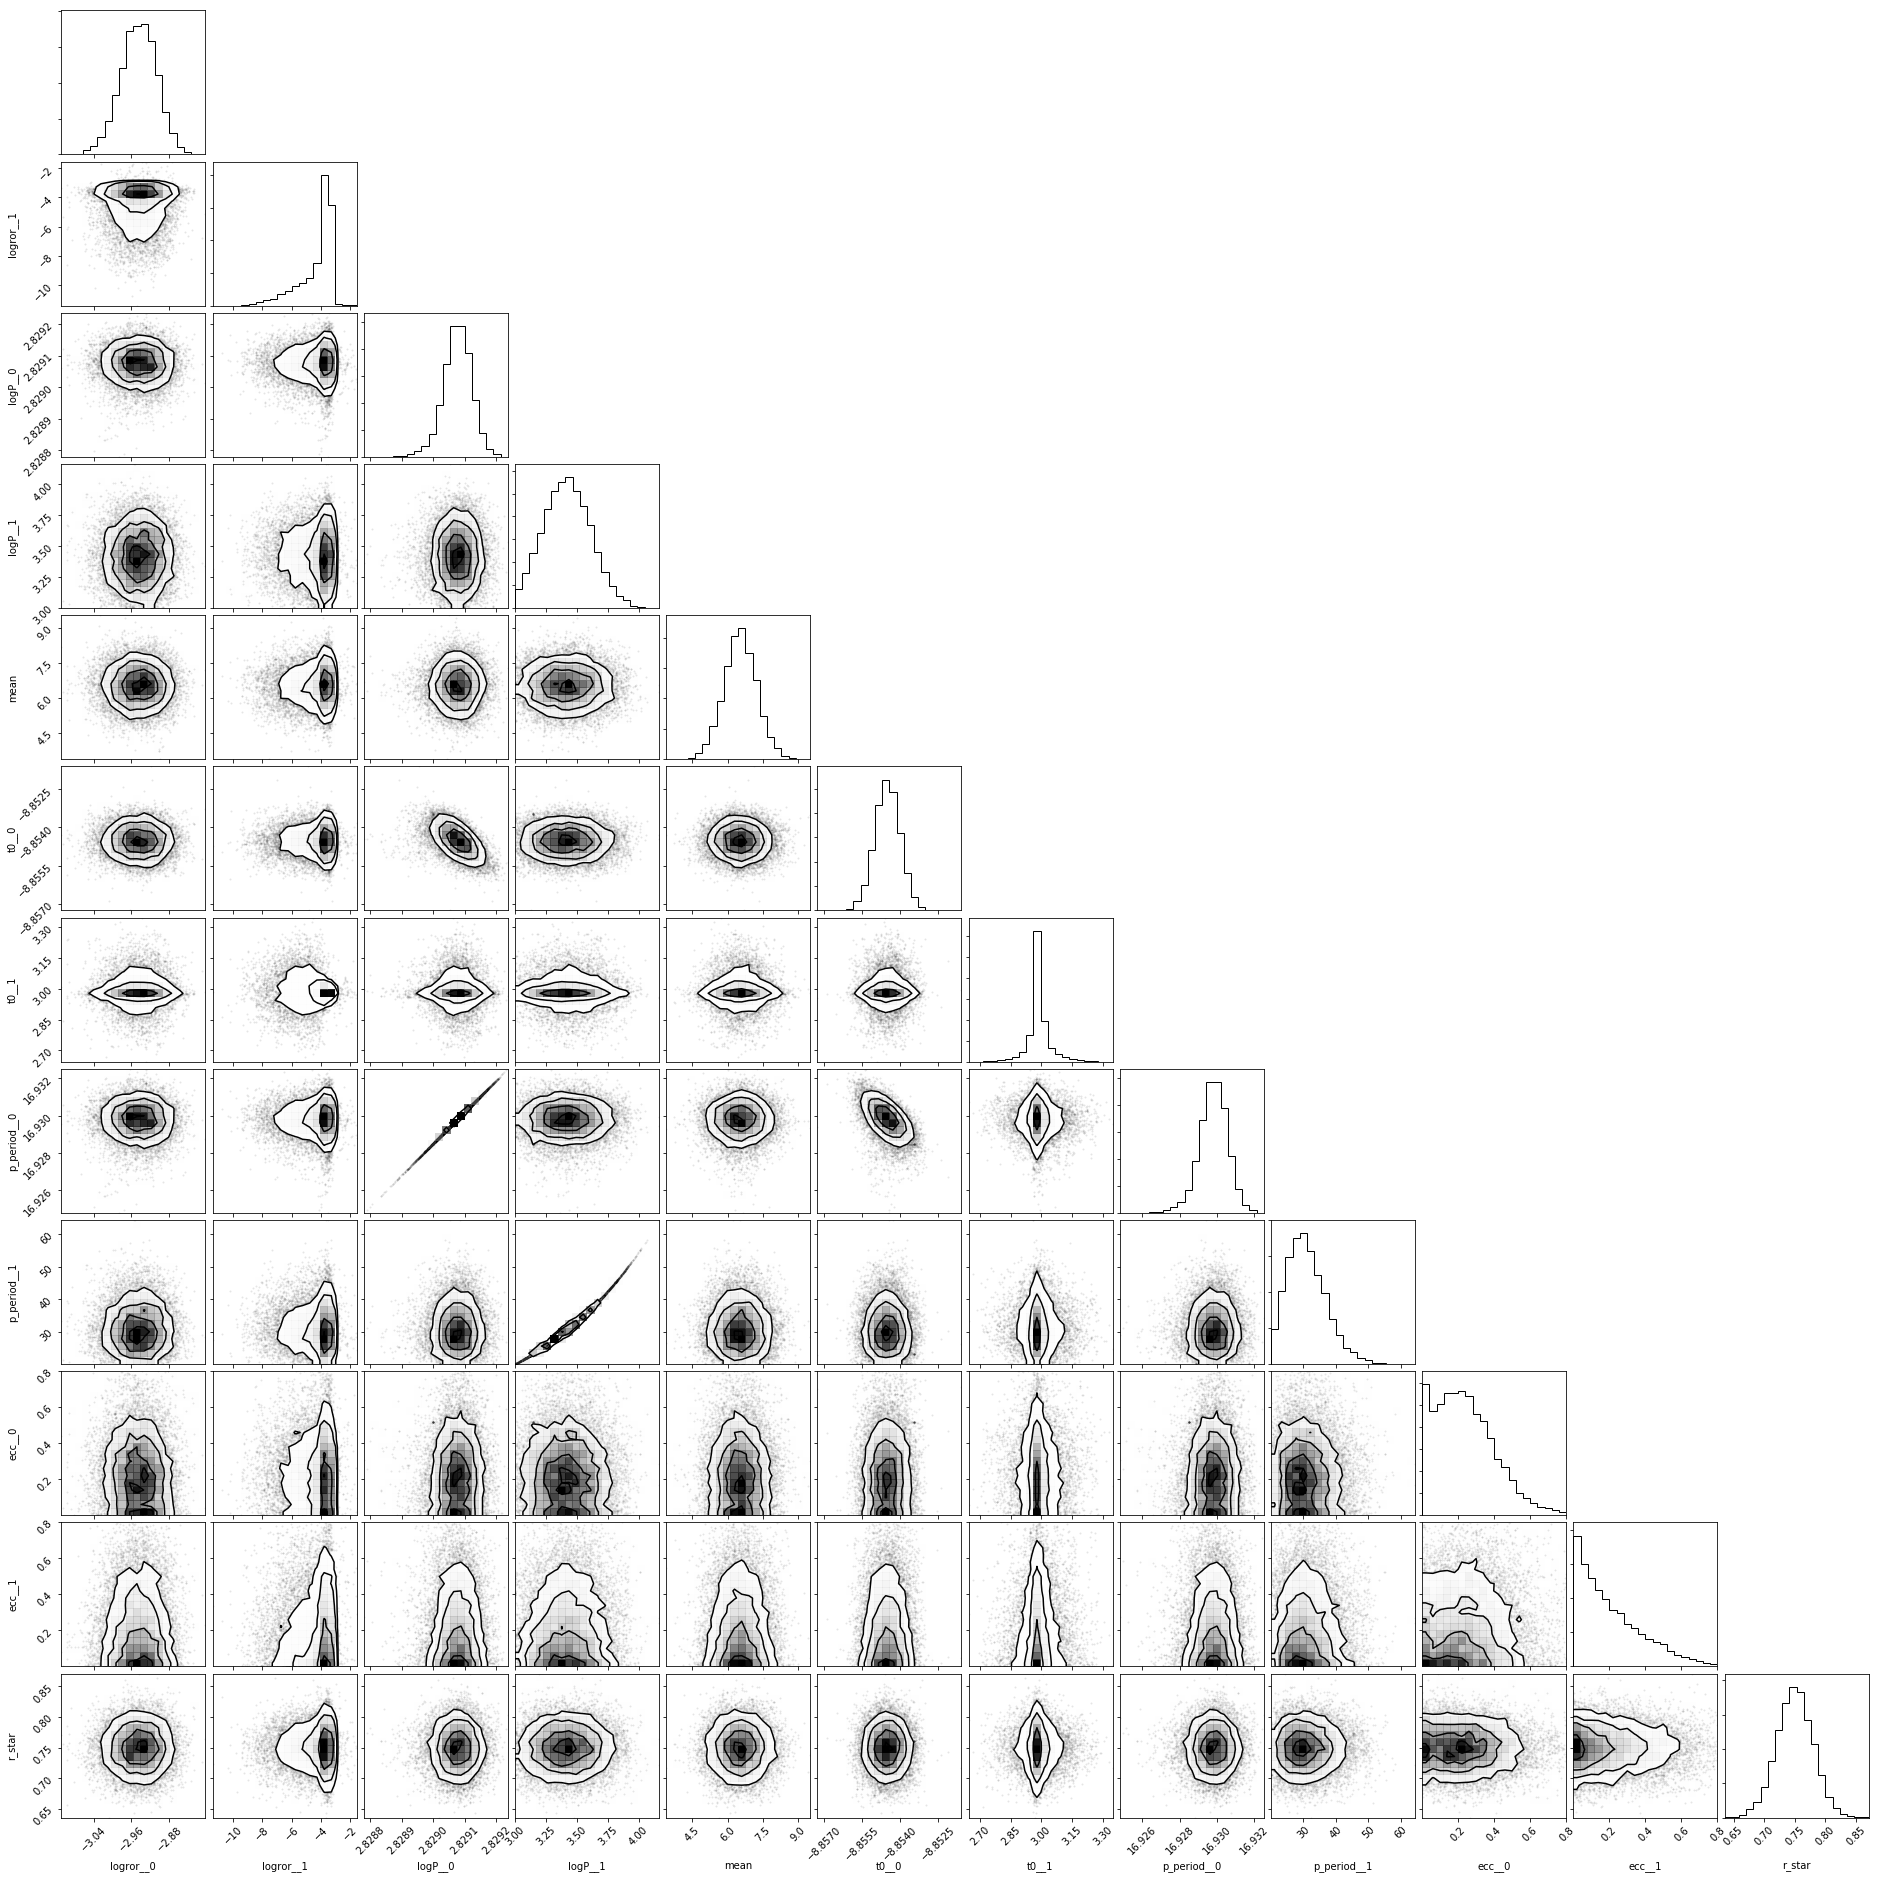

In [34]:
import corner
varnames = ["logror", "logP", 'mean', 't0', 'p_period', 'ecc', 'r_star']
samples = pm.trace_to_dataframe(trace, varnames=varnames)
samples = samples.loc[samples.logP__0 < 2.8304]
corner.corner(samples);

In [94]:
pm.save_trace(trace)

'.pymc_1.trace'

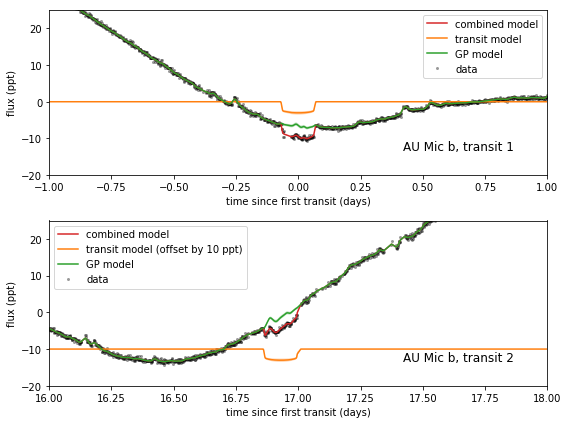

In [35]:
pmask = trace["p_period"][:, 0] < 16.96
pred = np.percentile(trace["light_curve"][pmask] + trace["mean"][pmask, None] +
                     trace["pred"][pmask], [5,50,95], axis=0)
pred1 = np.percentile(trace["light_curve"][pmask], [5,50,95], axis=0)
pred2 = np.percentile(trace["pred"][pmask] + trace["mean"][pmask, None], [5,50,95], axis=0)

fig,  [ax1, ax2] = plt.subplots(2,1, figsize=[8, 6])
time = x[mask] - np.median(trace['t0'][pmask,0])

ax1.plot(time, pred[1], color='C3', label = 'combined model')
art = ax1.fill_between(time, pred[0], pred[2], color="C3", alpha=0.3,
                       zorder=1000)
art.set_edgecolor("none")

ax1.plot(time, pred1[1], color='C1', label = 'transit model')
art = ax1.fill_between(time, pred1[0], pred1[2], color="C1", alpha=0.3,
                       zorder=1000)
art.set_edgecolor("none")

ax1.plot(time, pred2[1], color='C2', label = 'GP model')
art = ax1.fill_between(time, pred2[0], pred2[2], color="C2", alpha=0.3,
                       zorder=1000)
art.set_edgecolor("none")

ax1.plot(time, y[mask], ".k", label="data",
         alpha=0.4, zorder=-1000, mec="none")

ax1.set_xlim(-1,1)
ax1.set_ylim(-20, 25)

ax1.legend()
ax1.set_xlabel("time since first transit (days)")
ax1.set_ylabel("flux (ppt)")

ax1.annotate('AU Mic b, transit 1', (0.7, 0.1), xycoords="axes fraction",
             xytext=(5, 5), textcoords="offset points",
             ha="left", va="bottom", fontsize=12)

ax2.plot(time, pred[1], color='C3', label = 'combined model')
art = ax2.fill_between(time, pred[0], pred[2], color="C3", alpha=0.3,
                       zorder=1000)
art.set_edgecolor("none")

ax2.plot(time, pred1[1] -10, color='C1', label = 'transit model (offset by 10 ppt)')
art = ax2.fill_between(time, pred1[0] -10, pred1[2]-10, color="C1", alpha=0.3,
                       zorder=1000)
art.set_edgecolor("none")

ax2.plot(time, pred2[1], color='C2', label = 'GP model')
art = ax2.fill_between(time, pred2[0], pred2[2], color="C2", alpha=0.3,
                       zorder=1000)
art.set_edgecolor("none")

ax2.plot(time, y[mask], ".k", label="data",
         alpha=0.4, zorder=-1000, mec="none")

ax2.set_xlim(16,18)
ax2.set_ylim(-20, 25)
ax2.legend()
ax2.set_xlabel("time since first transit (days)")
ax2.set_ylabel("flux (ppt)")

ax2.annotate('AU Mic b, transit 2', (0.7, 0.1), xycoords="axes fraction",
             xytext=(5, 5), textcoords="offset points",
             ha="left", va="bottom", fontsize=12)

# ax3.plot(time, pred[1], color='C3', label = 'combined model')
# art = ax3.fill_between(time, pred[0], pred[2], color="C3", alpha=0.3,
#                        zorder=1000)
# art.set_edgecolor("none")

# ax3.plot(time, pred1[1], color='C1', label = 'transit model')
# art = ax3.fill_between(time, pred1[0], pred1[2], color="C1", alpha=0.3,
#                        zorder=1000)
# art.set_edgecolor("none")

# ax3.plot(time, pred2[1], color='C2', label = 'GP model')
# art = ax3.fill_between(time, pred2[0], pred2[2], color="C2", alpha=0.3,
#                        zorder=1000)
# art.set_edgecolor("none")

# ax3.plot(time, y[mask], ".k", label="data",
#          alpha=0.4, zorder=-1000, mec="none")

# ax3.set_xlim(11, 13)
# ax3.set_ylim(-20, 25)
# ax3.legend()
# ax3.set_xlabel("time since first transit (days)")
# ax3.set_ylabel("flux (ppt)")

# ax3.annotate('AU Mic c, transit 1', (0.7, 0.1), xycoords="axes fraction",
#              xytext=(5, 5), textcoords="offset points",
#              ha="left", va="bottom", fontsize=12)

plt.tight_layout()
plt.savefig('transits-GP-v3.png', dpi=200)

In [72]:
q = xo.get_samples_from_trace(trace)

In [75]:
[q1 for q1 in q]

[{'mean': 5.794966477209423,
  'logs2': -2.275282881036092,
  'logS': -5.54786944911264,
  'logw': 4.368410183650764,
  'logamp': 5.54852271394925,
  'logperiod': 1.5897022929752058,
  'logQ0': 2.713620405395783,
  'logdeltaQ': 14.956292247499338,
  'mix_interval__': -0.185577231774714,
  'u_star_quadlimbdark__': array([-1.49008246,  2.01031012]),
  'r_star': 0.6473386190305892,
  'logrho_star': 0.12807397224056238,
  'logP': array([2.83186698, 3.56742246]),
  't0': array([-8.87863403,  2.9702218 ]),
  'logror_upperbound__': array([0.61586969, 1.04978833]),
  'b_param_interval__': array([-1.21898733,  1.37901562]),
  'ecc_interval__': array([ 0.12097776, -0.31840324]),
  'omega_angle__': array([[-0.65329057, -1.12198123],
         [ 0.03426459, -0.35292403]]),
  'period': 4.90228926510961,
  'mix': 0.4537383825490712,
  'u_star': array([ 0.75637836, -0.32753183]),
  'rho_star': 1.1366370791788123,
  'logror': array([-3.05523873, -4.06101912]),
  'ror': array([0.04711147, 0.01723145]),


(-20, 25)

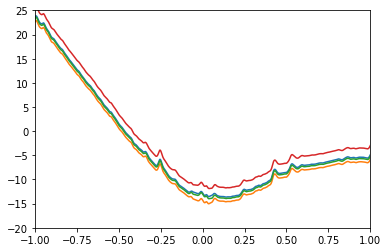

In [93]:
plt.plot(time, trace.get_values('pred', burn=1000, chains=[2])[1])
plt.plot(time, trace.get_values('pred', burn=1000, chains=[2])[100])
plt.plot(time, trace.get_values('pred', burn=1000, chains=[2])[1000])
plt.plot(time, trace.get_values('pred', burn=1000, chains=[2])[1500])
plt.xlim(-1, 1)
plt.ylim(-20, 25)

In [113]:
i = 1000
logS = trace.get_values('logS', burn=1000, chains=[2])[i]
logw = trace.get_values('logw', burn=1000, chains=[2])[i]
logamp = trace.get_values('logamp', burn=1000, chains=[2])[i]
period = trace.get_values('period', burn=1000, chains=[2])[i]
logQ0 = trace.get_values('logQ0', burn=1000, chains=[2])[i]
logdeltaQ = trace.get_values('logdeltaQ', burn=1000, chains=[2])[i]
mix = trace.get_values('mix', burn=1000, chains=[2])[i]
logs2 = trace.get_values('logs2', burn=1000, chains=[2])[i]
mean = trace.get_values('mean', burn=1000, chains=[2])[i]
light_curve = trace.get_values('light_curve', burn=1000, chains=[2])[i]

In [114]:
term1 = xo.gp.terms.SHOTerm(log_S0=logS, log_w0=logw, Q=1/np.sqrt(2))
term2 = xo.gp.terms.RotationTerm(
    log_amp=logamp,
    period=period,
    log_Q0=logQ0,
    log_deltaQ=logdeltaQ,
    mix=mix
)

In [115]:
kernel = term1 + term2
gp = xo.gp.GP(kernel, x[mask], yerr[mask]**2 + tt.exp(logs2), J=6)

In [116]:
yvals = y[mask] - mean - light_curve
xvals = x[mask]
gp.predict(xvals[0:10])

INFO (theano.gof.compilelock): Refreshing lock /home/tom/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.1-64/lock_dir/lock
INFO:theano.gof.compilelock:Refreshing lock /home/tom/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.1-64/lock_dir/lock


AttributeError: 'GP' object has no attribute 'z'

In [38]:
samples = pm.trace_to_dataframe(trace)

In [45]:
q = np.percentile(samples.loc[:, ['p_period__1', 'r_ple__1', 't0__1', 'ror__1', 'b__1', 'ecc__1']], [16,50,84], axis=0)

In [46]:
print(q[1])
print(q[2] - q[1])
print(q[1] - q[0])

[3.03994050e+01 1.85001541e+00 2.98026113e+00 2.27642613e-02
 5.23014074e-01 1.66769492e-01]
[6.54367416 0.78297107 0.038619   0.00936811 0.27843932 0.23252138]
[5.25367695 1.523447   0.02495522 0.01876242 0.34476662 0.12670708]


In [47]:
np.percentile(samples.loc[:, ['t0__1']], [16,50,84], axis=0) + ref_time

array([[1342.19674843],
       [1342.22170366],
       [1342.26032265]])

In [49]:
1342.26032265- 1342.22170366

0.03861899000003177

In [50]:
1342.22170366-1342.19674843

0.02495522999993227

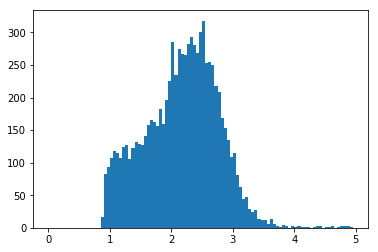

In [66]:
plt.hist(samples.loc[samples.logror__1 > -4.5, 'r_ple__1'],bins=np.arange(0,5,0.05));

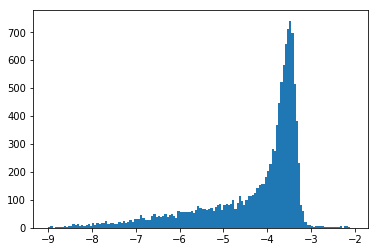

In [62]:
plt.hist(samples.loc[:, 'logror__1'],bins=np.arange(-9,-2,0.05));

In [73]:
np.percentile(samples.loc[samples.logror__1 > -4.5, 'p_period__1'], [16,50,84])

array([25.02009874, 30.17751827, 36.7597901 ])

In [71]:
2.75476141-2.22395897

0.53080244

In [ ]:
from scipy.optimize import curve_fit

ytt,xtt,_= plt.hist(samples.loc[: 'p_period__1'],100,alpha=.3,label='data')

xtt=(xtt[1:]+xtt[:-1])/2 # for len(x)==len(y)

def gauss(x,mu,sigma,A):
    return A*np.exp(-(x-mu)**2/2/sigma**2)

def bimodal(x,mu1,sigma1,A1,mu2,sigma2,A2):
    return gauss(x,mu1,sigma1,A1)+gauss(x,mu2,sigma2,A2)

expected=(1,.2,250,2,.2,125)
params,cov=curve_fit(bimodal,xtt,ytt,expected)
sigma=np.sqrt(np.diag(cov))
plt.plot(xtt,bimodal(xtt,*params),color='red',lw=3,label='model')
legend()
print(params,'\n',sigma)  

KeyboardInterrupt: 

In [9]:
spitzer = pd.read_csv('spitzer.csv')

SyntaxError: invalid syntax (<ipython-input-11-f686442465f1>, line 1)

In [13]:
from astropy.time import Time

In [10]:
st = Time(spitzer.BMJD, format='mjd', scale='tdb')
time_spit = st.jd - 2457000

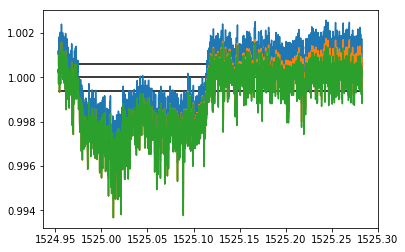

In [20]:
plt.plot(time_spit, spitzer.SAP_flux)
plt.plot(time_spit, spitzer.SAP_pld)
plt.plot(time_spit, spitzer.SAP_pld_ramp)

plt.hlines(spitzer.SAP_pld_ramp[1500:2000].mean(), time_spit.min(), time_spit.max())
plt.hlines(spitzer.SAP_pld_ramp[1500:2000].mean()+spitzer.SAP_pld_ramp[1500:2000].std(),
           time_spit.min(), time_spit.max())
plt.hlines(spitzer.SAP_pld_ramp[1500:2000].mean()-spitzer.SAP_pld_ramp[1500:2000].std(),
           time_spit.min(), time_spit.max())

In [21]:
spitzer.SAP_pld_ramp[1500:2000].std()

0.0006285249731535076

In [22]:
flux_err

array([0.00021623, 0.00020605, 0.00020641, ..., 0.00022084, 0.00022095,
       0.00022104], dtype=float32)

In [25]:
np.diff(time_spit) * 86400

array([13.74951303, 13.85842413, 14.09680545, ..., 13.81927729,
       13.74657601, 14.19268101])

In [45]:
y_spitzer.values

array([ 0.26496245,  0.22736398,  0.36988758, ..., -1.17720462,
       -0.70826838, -0.75519954])

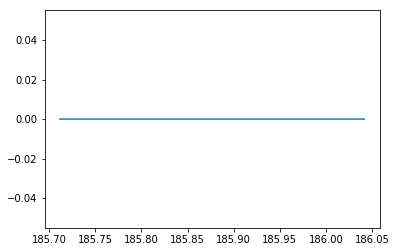

In [33]:
plt.plot(x_spitzer, map_soln0['light_curve_spitzer'])

In [30]:
-8.8343251 + (8.4633*23)

185.8215749

In [26]:
texp, texp_spitzer

(0.001388888888888889, 0.00016070157289505005)

In [84]:
with model0:
    orbit = xo.orbits.KeplerianOrbit(
                r_star=map_soln0['r_star'],
                period=map_soln0['p_period'], t0=map_soln0['t0'], b=map_soln0['b'],
                rho_star=map_soln0['rho_star'], ecc=map_soln0['ecc'], omega=map_soln0['omega'])
    lc = xo.StarryLightCurve(map_soln0['u_star_spitzer']).get_light_curve(
                orbit=orbit, r=map_soln0['r_pl'], t=np.arange(184,188,0.01), texp=texp)*1e3
    

In [85]:
q = lc.eval()

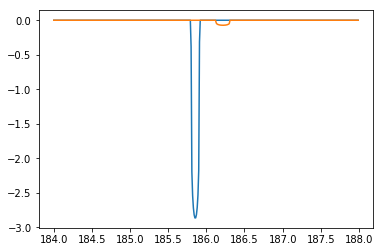

In [86]:
plt.plot(np.arange(184,188,0.01), q)

In [97]:
map_soln0['t0'][0] + (map_soln0['p_period'][0] * 23)

185.80899999999997

In [95]:
map_soln0['p_period'][0]

8.463

In [114]:
pred_spitzer

NameError: name 'pred_spitzer' is not defined